# Team Benchmark

**Authors:** Marissa Nicole Esteban, Gabe Krishnadasan, Diana Montoya-Herrera, Gabe Seidl, Madeleine Woo

**Date:** 2/13/2024

In [56]:
#pip install seebuoy

In [57]:
# import libraries needed
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')
from seebuoy import NDBC
%matplotlib inline 

In [58]:
ndbc = NDBC()

# Information on NDBC's ~1800 buoys and gliders
wave_df = ndbc.stations()

# list all available data for all buoys
df_data = ndbc.available_data()

# Get info on NY Harbor Buoy
station_id = "44065"
ny_buoy = ndbc.get_data(station_id)

### Handling Missing Data

In [59]:
# missing data
total_na = ny_buoy.isnull().sum().sort_values(ascending=False)

total_rows = ny_buoy.isnull().count()
percent = (ny_buoy.isnull().sum()/ny_buoy.isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total_na, total_rows, percent], axis=1, keys=['Total NA', 'Total Rows', 'Percent'])
missing_data


,Total NA,Total Rows,Percent
wind_direction,6520,6520,100.000000
air_temp,6520,6520,100.000000
dewpoint,6520,6520,100.000000
visibility,6520,6520,100.000000
tide,6520,6520,100.000000
pressure_tendency,5516,6520,84.601227
dominant_period,4363,6520,66.917178
wave_height,3223,6520,49.432515
average_period,3223,6520,49.432515
mean_wave_direction,3223,6520,49.432515


In [60]:
# dropping cols where there is 100% NA
ny_buoy.dropna(axis=1, how='all', inplace=True)

# dropping rows where average_period is null
ny_buoy.dropna(subset=['average_period'], inplace=True)

# dropping rows wehre wave_height is null
ny_buoy.dropna(subset=['wave_height'], inplace=True)

In [61]:
from sklearn.impute import SimpleImputer

# Replace missing data with mode
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(ny_buoy)
ny_buoy_mode = pd.DataFrame(imputer.transform(ny_buoy), columns=ny_buoy.columns)

# Replace missing data with mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(ny_buoy)
ny_buoy_mean = pd.DataFrame(imputer.transform(ny_buoy), columns=ny_buoy.columns)

# Interpolate missing values using spline interpolation
ny_buoy_interpolated = ny_buoy.interpolate(method='spline', order=2)

In [62]:
# missing data after dropping cols and imputation
total_na = ny_buoy_mode.isnull().sum().sort_values(ascending=False)

total_rows = ny_buoy.isnull().count()
percent = (ny_buoy_mode.isnull().sum()/ny_buoy_mode.isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total_na, total_rows, percent], axis=1, keys=['Total NA', 'Total Rows', 'Percent'])
missing_data

,Total NA,Total Rows,Percent
wind_speed,0,3297,0.0
wind_gust,0,3297,0.0
wave_height,0,3297,0.0
dominant_period,0,3297,0.0
average_period,0,3297,0.0
mean_wave_direction,0,3297,0.0
pressure,0,3297,0.0
water_temp,0,3297,0.0
pressure_tendency,0,3297,0.0


### Handling Outliers

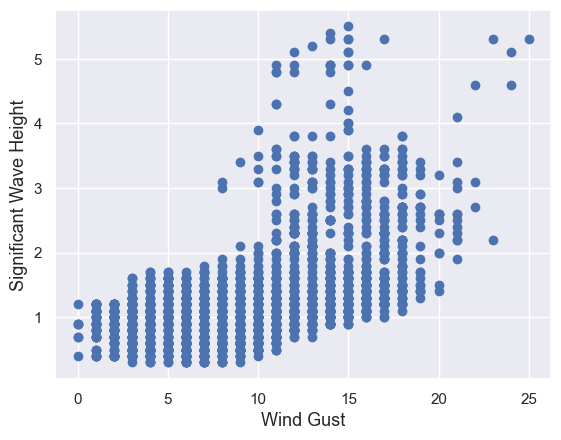

In [63]:
fig, ax = plt.subplots()
ax.scatter(x = ny_buoy['wind_gust'], y = ny_buoy['wave_height'])
plt.ylabel('Significant Wave Height', fontsize=13)
plt.xlabel('Wind Gust', fontsize=13)
plt.show()

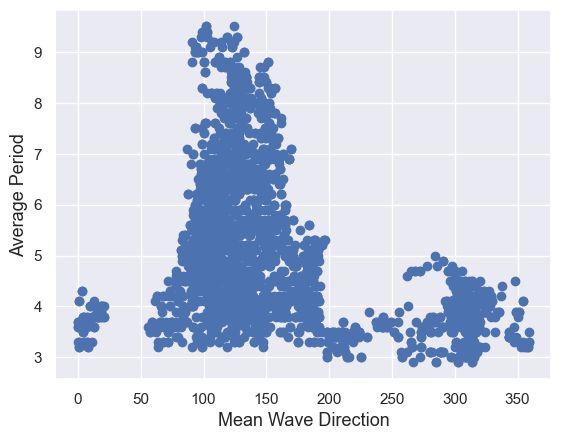

In [64]:
fig, ax = plt.subplots()
ax.scatter(x = ny_buoy['mean_wave_direction'], y = ny_buoy['average_period'],)
plt.ylabel('Average Period', fontsize=13)
plt.xlabel('Mean Wave Direction', fontsize=13)
plt.show()

In [65]:
# Remove non finite values
ny_buoy_mode = ny_buoy_mode[np.isfinite(ny_buoy_mode['wave_height'])]
ny_buoy_mean = ny_buoy_mean[np.isfinite(ny_buoy_mean['wave_height'])]
ny_buoy_interpolated = ny_buoy_interpolated[np.isfinite(ny_buoy_interpolated['wave_height'])]


 mu = 0.75 and sigma = 0.27



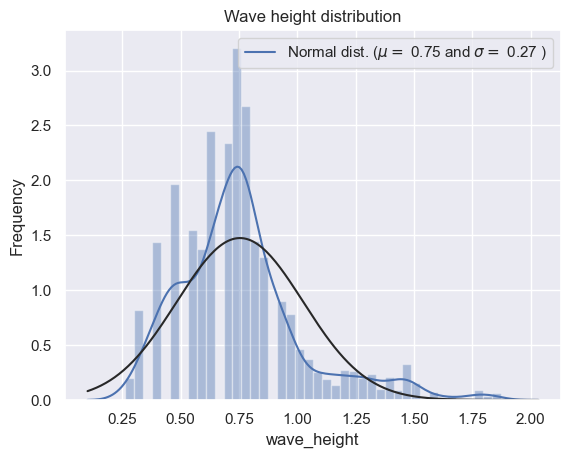

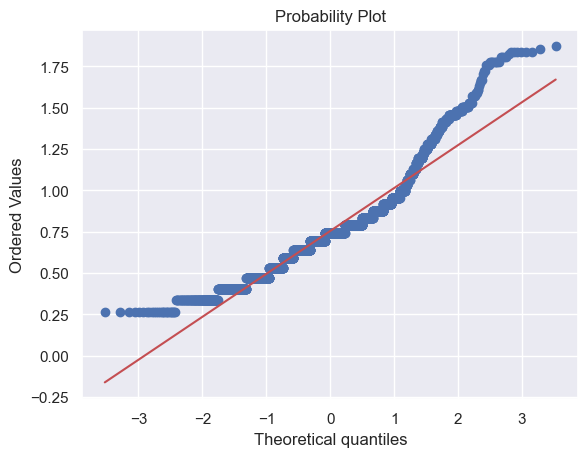

In [66]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
ny_buoy_mode["wave_height"] = np.log1p(ny_buoy_mode["wave_height"])
ny_buoy_mean["wave_height"] = np.log1p(ny_buoy_mean["wave_height"])
ny_buoy_interpolated["wave_height"] = np.log1p(ny_buoy_interpolated["wave_height"])


# Check the new distribution 
sns.distplot(ny_buoy_mode['wave_height'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(ny_buoy_mode['wave_height'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Wave height distribution')

# Get also the QQ-plot
fig = plt.figure()
res = probplot(ny_buoy_mode['wave_height'], plot=plt)
plt.show()


 mu = 1.79 and sigma = 0.22



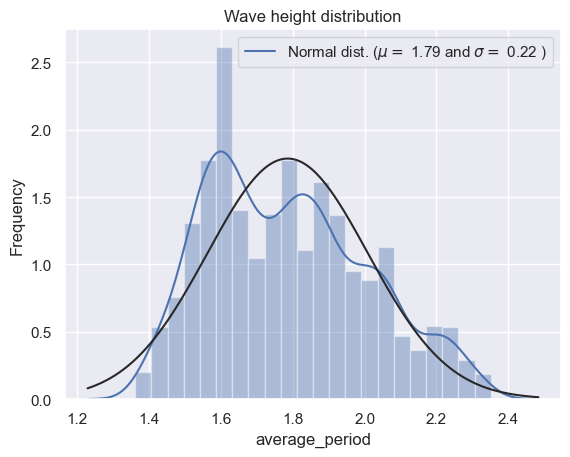

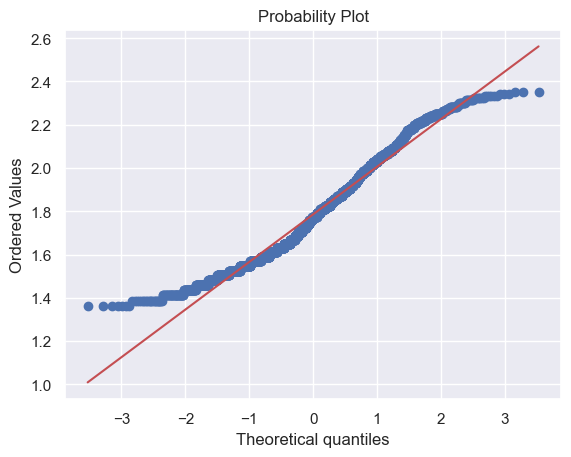

In [67]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
ny_buoy_mode["average_period"] = np.log1p(ny_buoy_mode["average_period"])
ny_buoy_mean["average_period"] = np.log1p(ny_buoy_mean["average_period"])
ny_buoy_interpolated["average_period"] = np.log1p(ny_buoy_interpolated["average_period"])

# Check the new distribution 
sns.distplot(ny_buoy_mode['average_period'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(ny_buoy_mode['average_period'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Wave height distribution')

# Get also the QQ-plot
fig = plt.figure()
res = probplot(ny_buoy_mode['average_period'], plot=plt)
plt.show()

### Data Analysis and Visualization

In [68]:
from sklearn.preprocessing import LabelEncoder

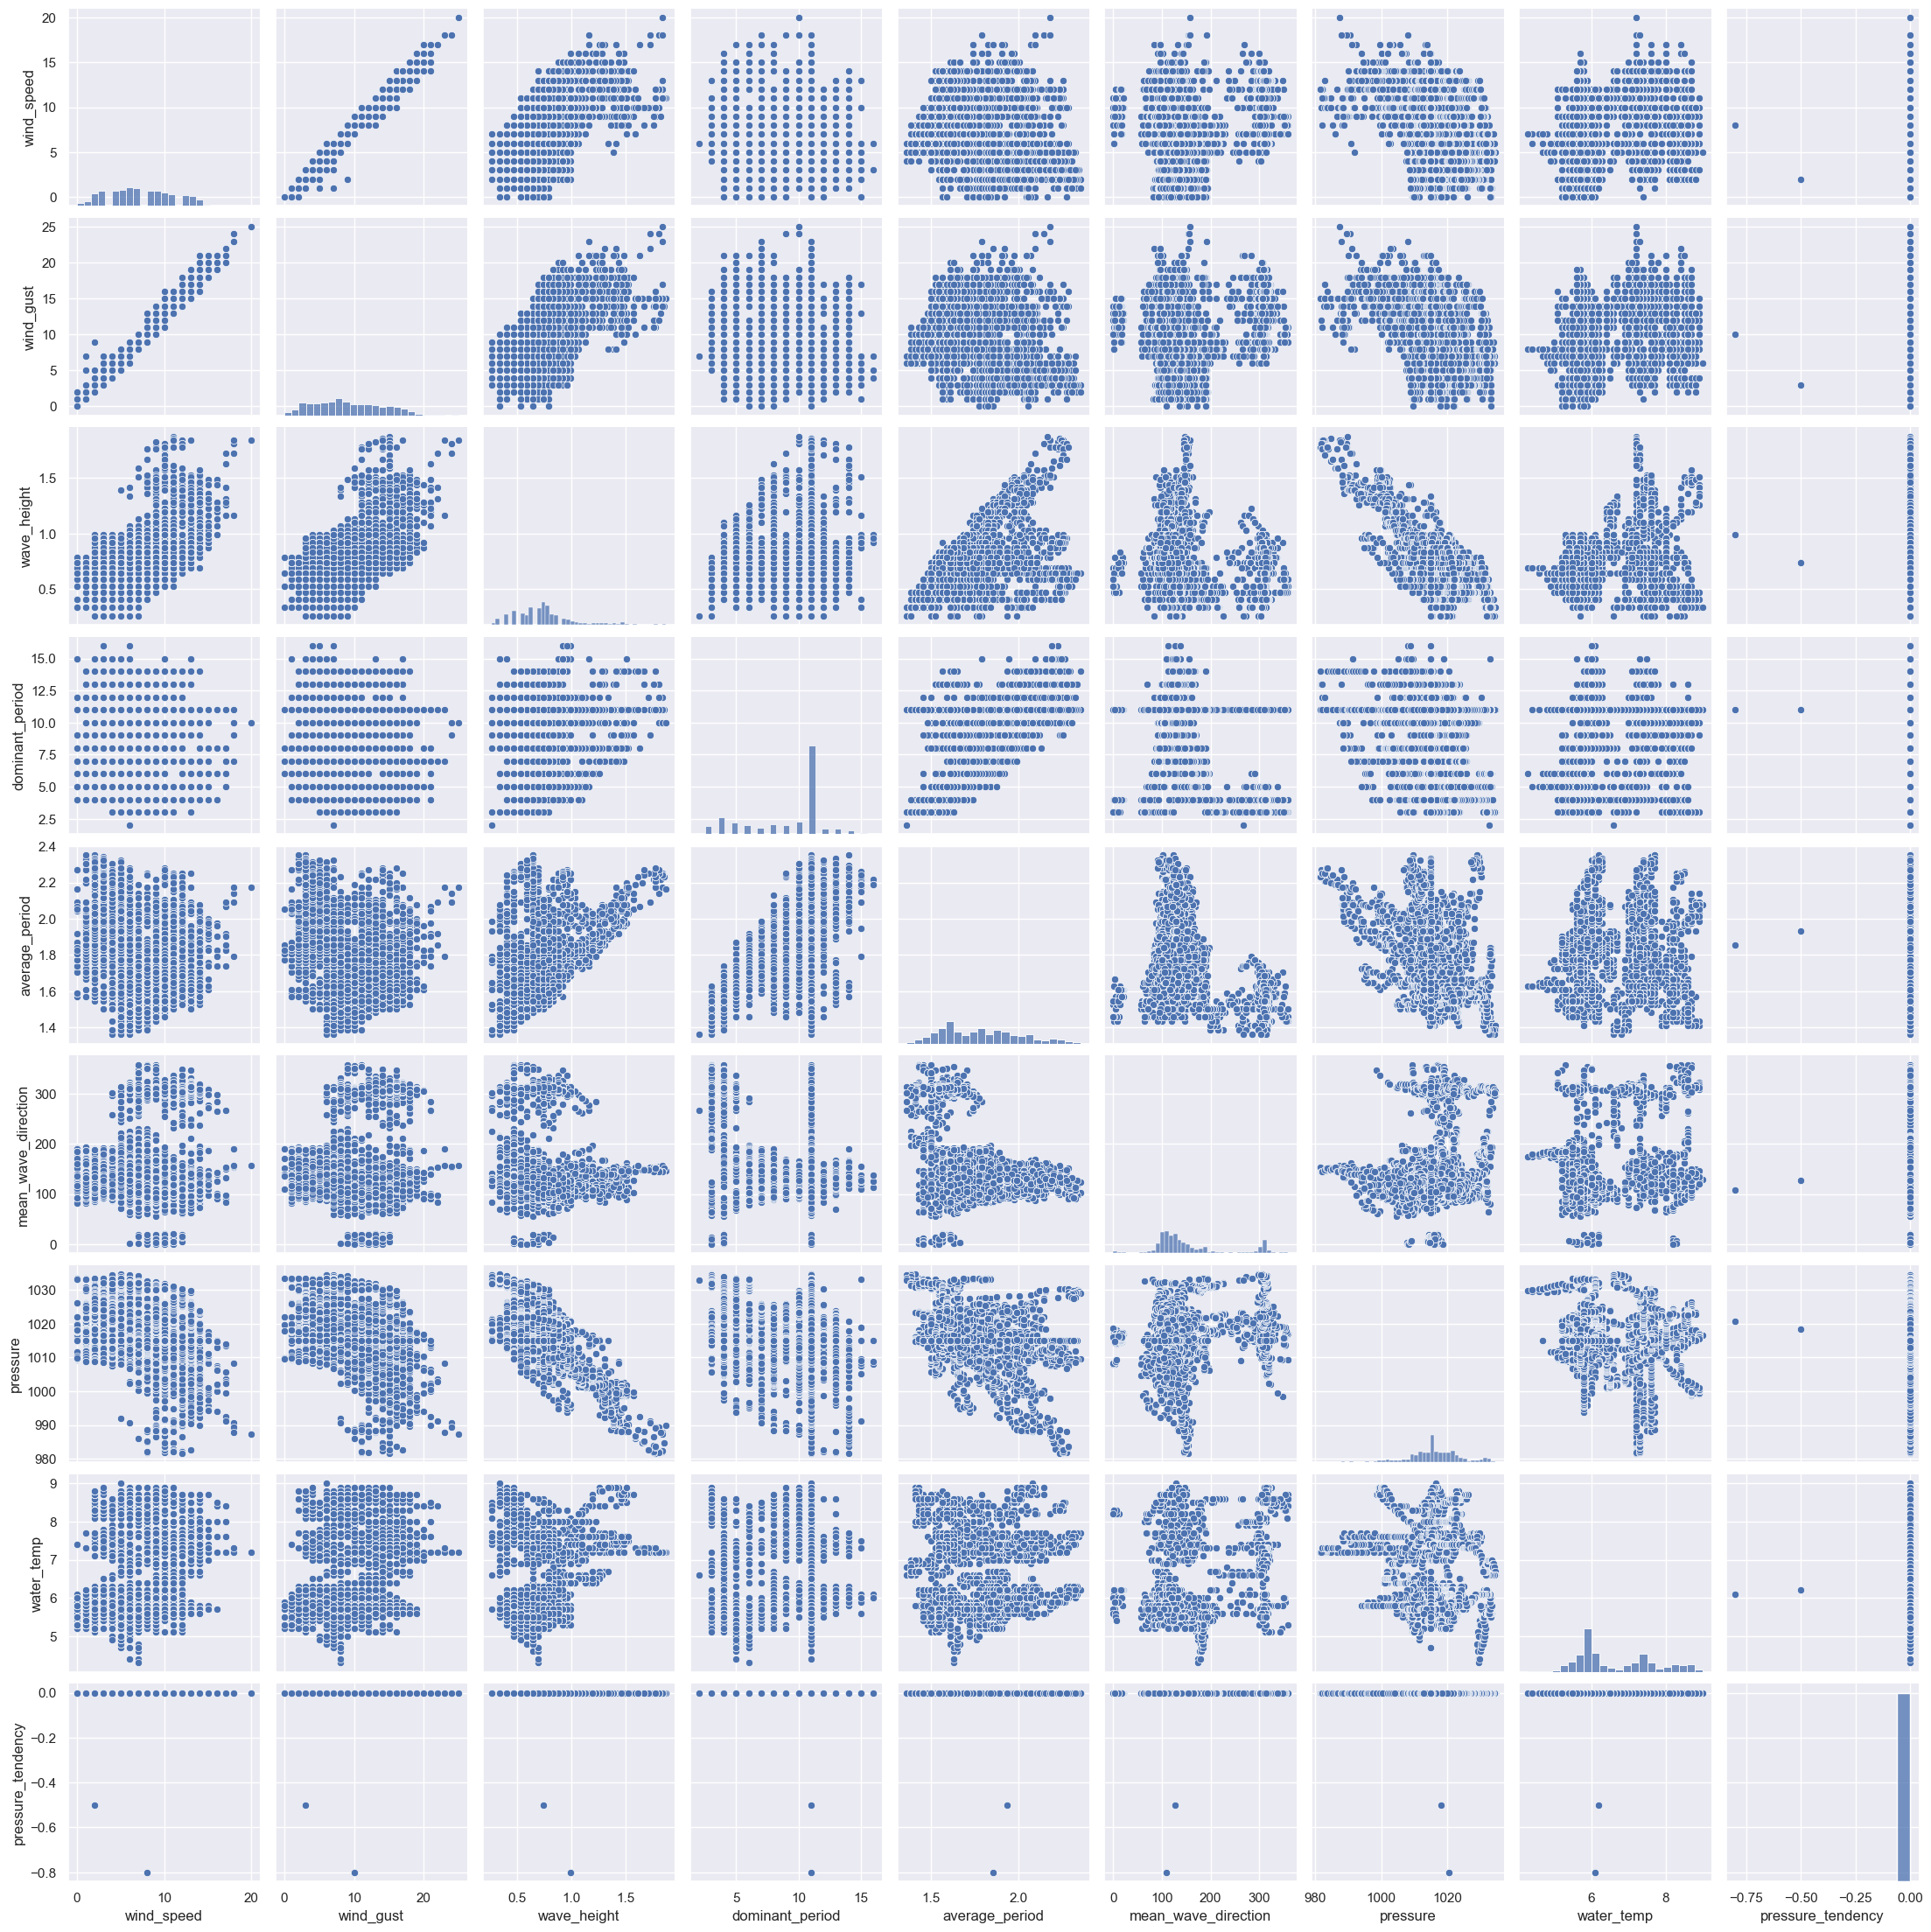

In [69]:
# scatterplot
sns.set()
cols = ['wind_speed', 'wind_gust', 'wave_height', 
        'dominant_period', 'average_period', 'mean_wave_direction', 
        'pressure', 'water_temp',
        'pressure_tendency']
sns.pairplot(ny_buoy_mode[cols], size = 2.5)
plt.show();

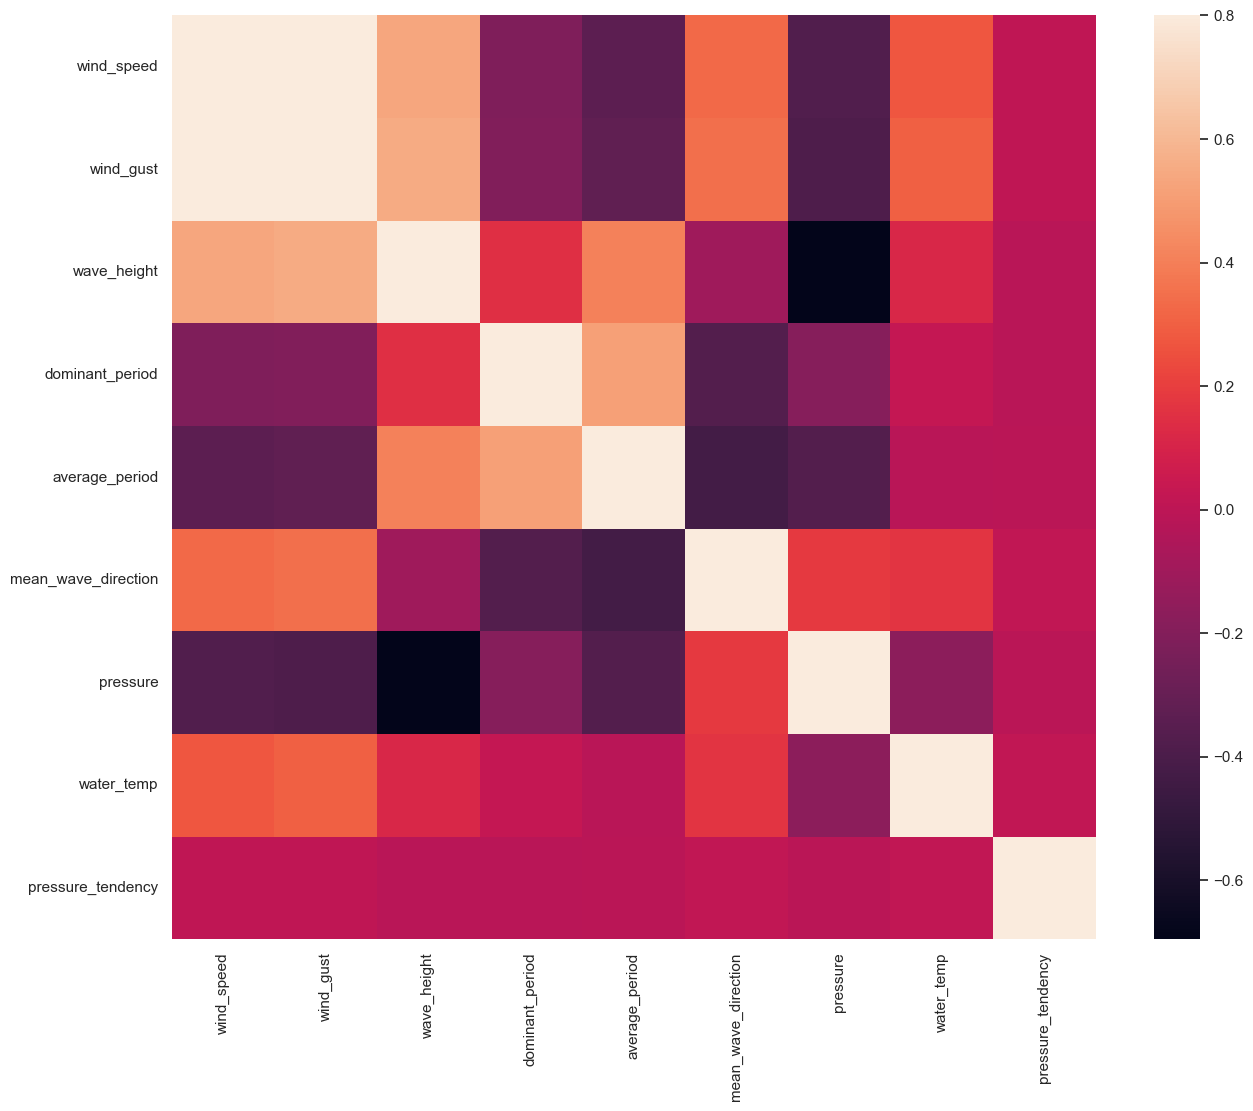

In [70]:
# Correlation map to see how conditions are correlated with wave height and average period
corrmat = ny_buoy_mode.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

# Data Analytics
## Using algorithms on different imputations
* [ny_buoy_mode](#mode)
* [ny_buoy_mean](#mean)
* [ny_buoy_interpolated](#interpolate)

### Imputed on mode <a class="anchor" id="mode"></a>

In [71]:
import sys

!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install lightgbm

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb

In [72]:
train_df = ny_buoy[ny_buoy_mode.columns.difference(['wave_height', 'average_period'])]
train_df.head()

,dominant_period,mean_wave_direction,pressure,pressure_tendency,water_temp,wind_gust,wind_speed
date,,,,,,,
2024-01-01 00:10:00,NaN,190.0,1015.4,NaN,8.6,8.0,6.0
2024-01-01 00:20:00,8.0,190.0,1015.3,NaN,8.6,8.0,7.0
2024-01-01 00:50:00,7.0,175.0,1015.2,NaN,8.5,7.0,5.0
2024-01-01 01:10:00,NaN,178.0,1015.1,NaN,8.5,7.0,5.0
2024-01-01 01:20:00,8.0,178.0,1015.1,NaN,8.5,7.0,5.0


In [73]:
# Validation function for wave height
n_folds = 5

def rmse_cv(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse = np.sqrt(-cross_val_score(model, train_df, ny_buoy_mode.wave_height, scoring="neg_mean_squared_error", cv = kf))
    return rmse

In [74]:
lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)

In [75]:
neigh = KNeighborsRegressor(n_neighbors=10)

In [76]:
rf = RandomForestRegressor(n_estimators=100)

In [77]:
dt = DecisionTreeRegressor(max_depth = 10)

In [78]:
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)

In [79]:
model_lgb = lgb.LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

In [82]:
score_dt = rmse_cv(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

Decision Tree Regression score: 0.2134 (0.0418)



In [83]:
score_rf = rmse_cv(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

Random Forest Regression score: 0.1947 (0.0453)



In [84]:
score_xg = rmse_cv(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

Xgboost score: 0.1811 (0.0230)



In [85]:
score_lgbm = rmse_cv(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 2637, number of used features: 6
[LightGBM] [Info] Start training from score 0.766951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

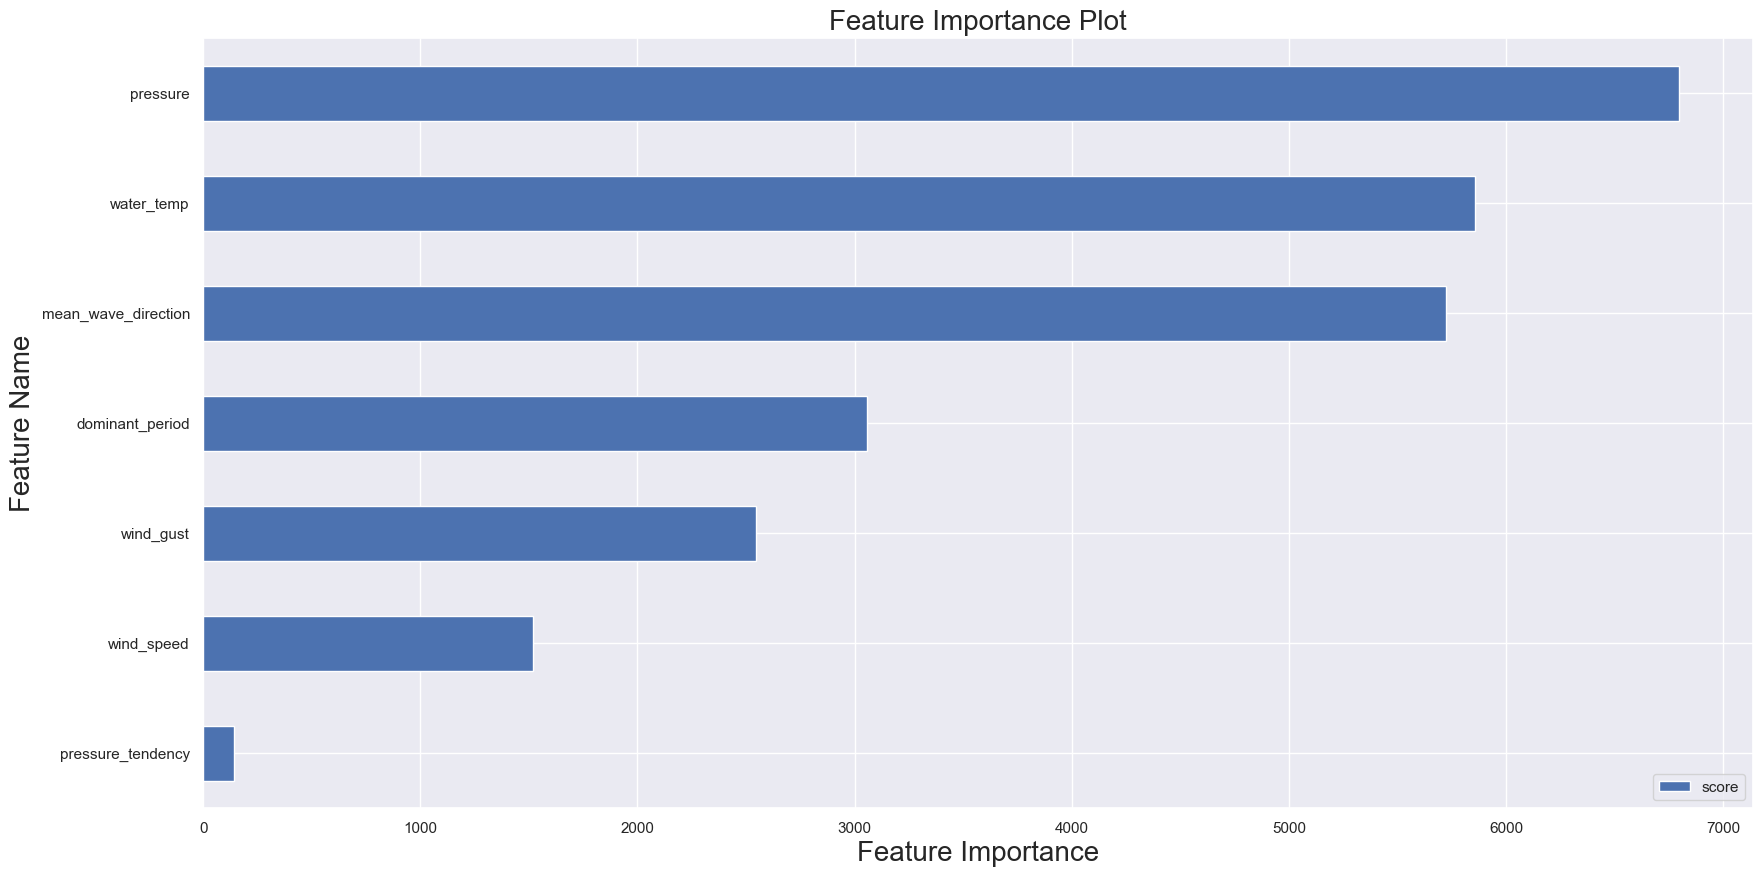

In [87]:
model = model_xgb.fit(train_df, ny_buoy_mode.wave_height) #fit model on entire dataset to get variable importance since we fit it on each fold
feature_important = model.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data[:20].plot(kind='barh', figsize = (20,10)).invert_yaxis(); ## plot top 20 features
plt.xlabel("Feature Importance",fontsize=20)
plt.ylabel("Feature Name",fontsize=20)
plt.title("Feature Importance Plot",fontsize=20)
plt.show()

#### Repeat Training Models, but for Average Period

In [88]:
# Validation function for wave height
n_folds = 5

def rmse_cv_period(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse_period = np.sqrt(-cross_val_score(model, train_df, ny_buoy_mode.average_period, scoring="neg_mean_squared_error", cv = kf))
    return rmse_period

In [92]:
score_dt = rmse_cv_period(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

Decision Tree Regression score: 0.2065 (0.0249)



In [93]:
score_rf = rmse_cv_period(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

Random Forest Regression score: 0.1898 (0.0299)



In [94]:
score_xg = rmse_cv_period(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

Xgboost score: 0.1692 (0.0452)



In [95]:
score_lgbm = rmse_cv_period(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 2637, number of used features: 6
[LightGBM] [Info] Start training from score 1.788935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 3297, number of used features: 6
[LightGBM] [Info] Start training from score 1.785600
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

<Axes: title={'center': 'LightGBM Feature Importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

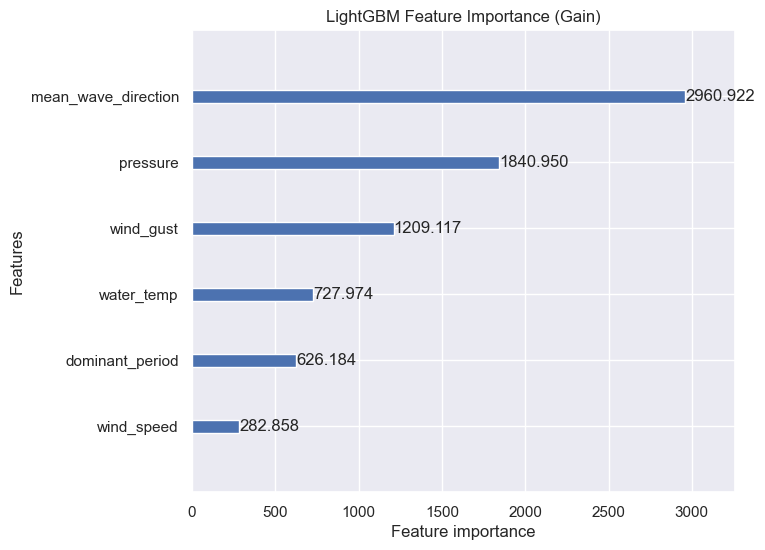

In [98]:
model = model_lgb.fit(train_df, ny_buoy_mode.average_period) #fit model on entire dataset to get variable importance since we fit it on each fold
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")

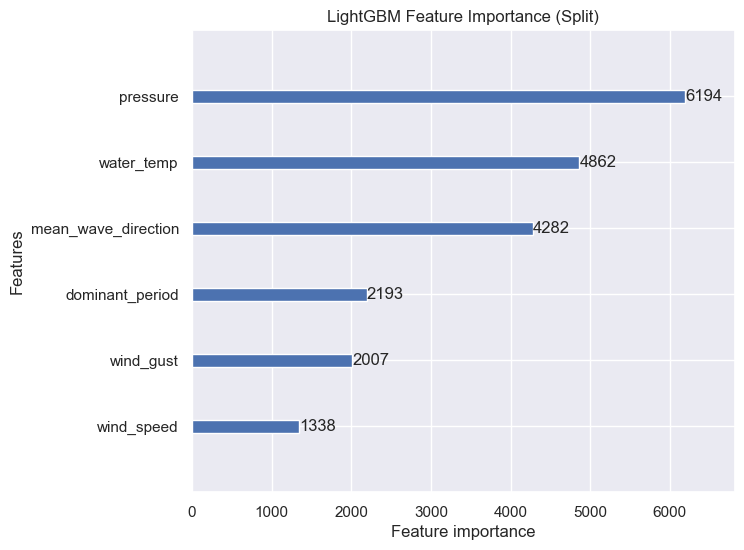

In [99]:
# Plot feature importance using Split
lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

### Imputed on mean <a class="anchor" id="mean"></a>

In [100]:
train_df = ny_buoy_mean[ny_buoy_mean.columns.difference(['wave_height', 'average_period'])]
train_df.head()

# Validation function for wave height
n_folds = 5

def rmse_cv(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse = np.sqrt(-cross_val_score(model, train_df, ny_buoy_mean.wave_height, scoring="neg_mean_squared_error", cv = kf))
    return rmse

lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)
neigh = KNeighborsRegressor(n_neighbors=10)
rf = RandomForestRegressor(n_estimators=100)
dt = DecisionTreeRegressor(max_depth = 10)
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)
model_lgb = lgb.LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

score_dt = rmse_cv(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

score_rf = rmse_cv(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

score_xg = rmse_cv(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

score_lgbm = rmse_cv(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

Decision Tree Regression score: 0.2249 (0.0529)

Random Forest Regression score: 0.1952 (0.0443)

Xgboost score: 0.1811 (0.0230)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 2637, number of used features: 6
[LightGBM] [Info] Start training from score 0.766951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

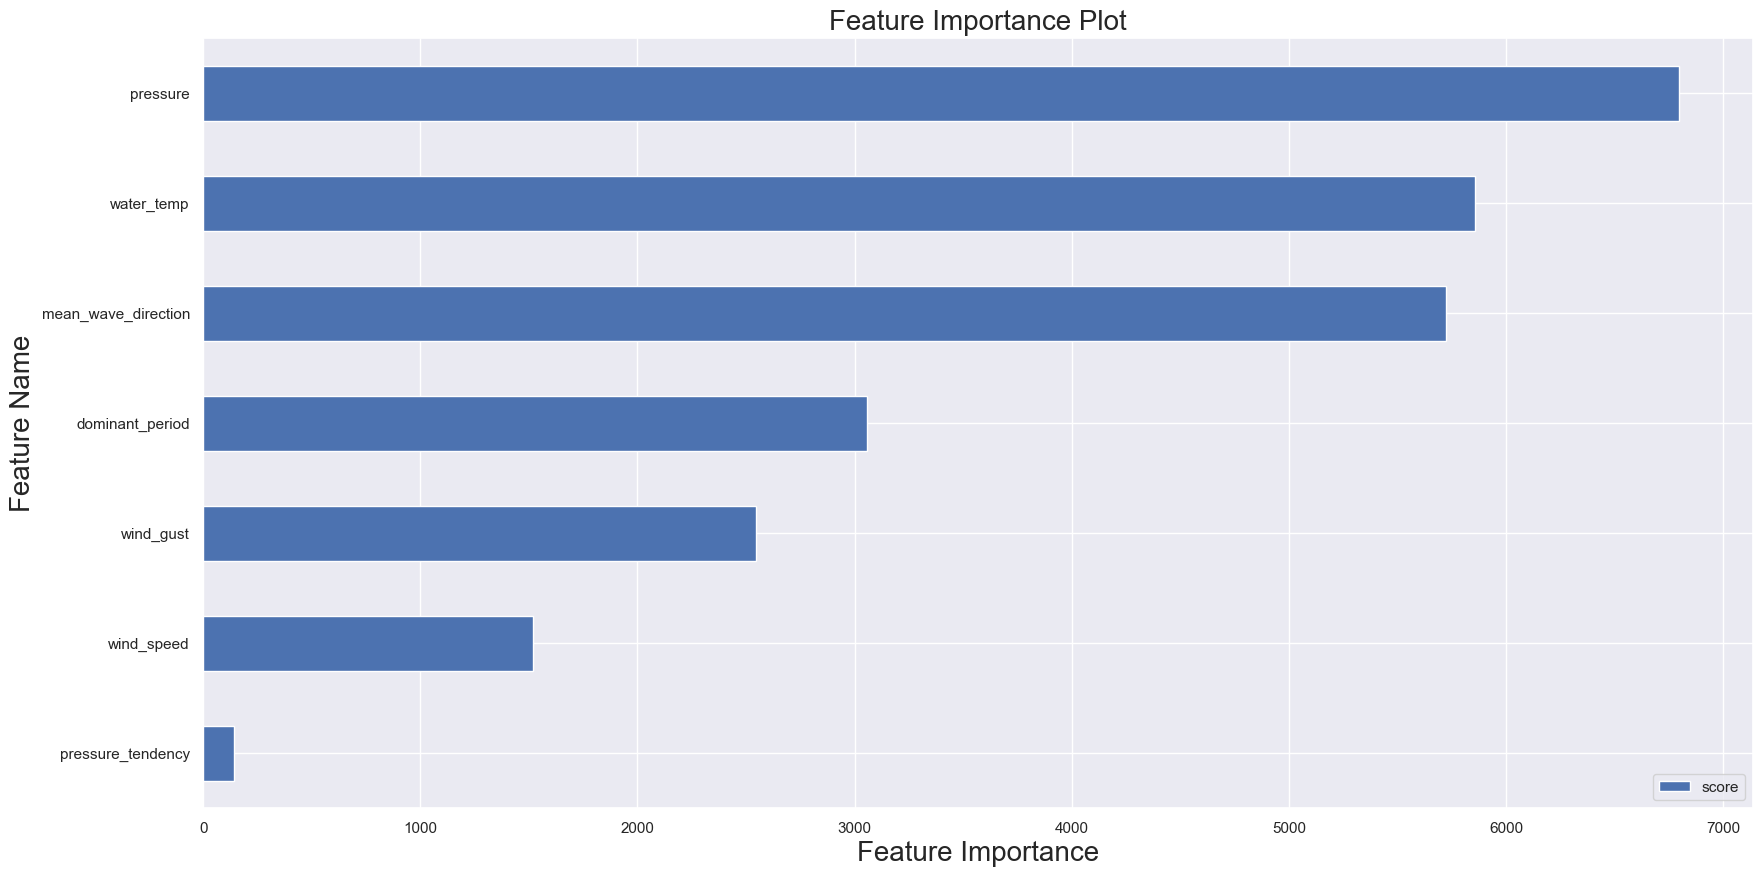

In [101]:
model = model_xgb.fit(train_df, ny_buoy_mean.wave_height) #fit model on entire dataset to get variable importance since we fit it on each fold
feature_important = model.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data[:20].plot(kind='barh', figsize = (20,10)).invert_yaxis(); ## plot top 20 features
plt.xlabel("Feature Importance",fontsize=20)
plt.ylabel("Feature Name",fontsize=20)
plt.title("Feature Importance Plot",fontsize=20)
plt.show()

#### Repeat Training Models, but for Average Period

In [ ]:
def rmse_cv(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse = np.sqrt(-cross_val_score(model, train_df, ny_buoy_mean.average_period, scoring="neg_mean_squared_error", cv = kf))
    return rmse

lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)
neigh = KNeighborsRegressor(n_neighbors=10)
rf = RandomForestRegressor(n_estimators=100)
dt = DecisionTreeRegressor(max_depth = 10)
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)
model_lgb = lgb.LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

score_dt = rmse_cv(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

score_rf = rmse_cv(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

score_xg = rmse_cv(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

score_lgbm = rmse_cv(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

### Imputed on interpolation <a class="anchor" id="interpolate"></a>

In [ ]:
train_df = ny_buoy_interpolated[ny_buoy_interpolated.columns.difference(['wave_height', 'average_period'])]
train_df.head()

# Validation function for wave height
n_folds = 5

def rmse_cv(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse = np.sqrt(-cross_val_score(model, train_df, ny_buoy_interpolated.wave_height, scoring="neg_mean_squared_error", cv = kf))
    return rmse

lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)
neigh = KNeighborsRegressor(n_neighbors=10)
rf = RandomForestRegressor(n_estimators=100)
dt = DecisionTreeRegressor(max_depth = 10)
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)
model_lgb = lgb.LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

score_dt = rmse_cv(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

score_rf = rmse_cv(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

score_xg = rmse_cv(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

score_lgbm = rmse_cv(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

In [ ]:
model = model_xgb.fit(train_df, ny_buoy_interpolated.wave_height) #fit model on entire dataset to get variable importance since we fit it on each fold
feature_important = model.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data[:20].plot(kind='barh', figsize = (20,10)).invert_yaxis(); ## plot top 20 features
plt.xlabel("Feature Importance",fontsize=20)
plt.ylabel("Feature Name",fontsize=20)
plt.title("Feature Importance Plot",fontsize=20)
plt.show()

#### Repeat Training Models, but for Average Period (interpolate)

In [ ]:
def rmse_cv(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse = np.sqrt(-cross_val_score(model, train_df, ny_buoy_interpolated.average_period, scoring="neg_mean_squared_error", cv = kf))
    return rmse

lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)
neigh = KNeighborsRegressor(n_neighbors=10)
rf = RandomForestRegressor(n_estimators=100)
dt = DecisionTreeRegressor(max_depth = 10)
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)
model_lgb = lgb.LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

score_dt = rmse_cv(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

score_rf = rmse_cv(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

score_xg = rmse_cv(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

score_lgbm = rmse_cv(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))